In [87]:
#importing all necessary packages
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
#from scipy.misc import factorial
import os
import re
import scvelo as scv

from sklearn.decomposition import PCA

#sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)
sc.settings.figdir="/data/bioinf/projects/data/2019_schROHT/2021_Comparison_HRO/results/"

In [69]:
import scvelo as scv
import scanpy as sc
scv.logging.print_versions()

scvelo==0.2.3  scanpy==1.7.1  anndata==0.7.5  loompy==2.0.16  numpy==1.19.1  scipy==1.6.0  matplotlib==3.3.1  sklearn==0.23.2  pandas==1.1.3  


# Functions
## Preprocessing the single cell data

In [70]:
def PreprocessSC(data_path, data_type):
    
    path = data_path
    
    # Build adata
    # var_names = HGNC symbols but adding ENSEMBLE gene IDs additionally
    # obs_names = Cell-IDs
    # -------------------------------------------------------------------- #
    global adata
    
    adata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
        
    genes = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')
    adata.var_names = genes[1]
    adata.var['gene_ids'] = genes[0].tolist()  
    adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
    adata.var_names_make_unique()
    
    # -------------------------------------------------------------------- #
    # -------------------------------------------------------------------- #
    # Starting preprocessing
    # Highest expressed genes
    # -------------------------------------------------------------------- #
    sc.pl.highest_expr_genes(adata, n_top=20)
    
    # Filtering based on min. expressed genes per cell and vice versa
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    # Prepare filtering for mitochondrial genes (based on HGNC)    
    # -------------------------------------------------------------------- #
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    
    # Save violin plot 
    # -------------------------------------------------------------------- #
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
    
    # Plot scatter plots
    # -------------------------------------------------------------------- #
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
    

In [170]:
## Clustering cells

In [71]:
def ClusterCells (adata_input, cutoff_mito, cutoff_ngenes, data_type, resolution_lv = 1):
    # Filter sc data
    # -----------------------------------------------------------------------
    global adata
    adata = adata_input
    adata = adata[adata.obs.n_genes_by_counts < cutoff_ngenes, :]
    adata = adata[adata.obs.pct_counts_mt < cutoff_mito, :]
    # Log raw data and Normalize sc data
    # -----------------------------------------------------------------------
    #adata.raw = sc.pp.log1p(adata, copy=True)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Filtering according to HVG
    # -----------------------------------------------------------------------
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

    sc.pl.highly_variable_genes(adata)
    adata = adata[:, adata.var.highly_variable]
    # Final step in data scaling and correction
    # -----------------------------------------------------------------------
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
    sc.pp.scale(adata, max_value=10)
    
    # Downstream Analysis
    # Calculate PCA
    # -----------------------------------------------------------------------
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca(adata , annotate_var_explained=True)
    sc.pl.pca_variance_ratio(adata, log=True)
    # Compute Neighbours for LV- clustering
    # -----------------------------------------------------------------------
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    sc.tl.louvain(adata, resolution = resolution_lv)
    # Plot umap embedding of louvain clustering
    # -----------------------------------------------------------------------
    sc.pl.umap(adata, color=['louvain'],save = '_LouvainClustering_'+ str(data_type) +".svg")
    #adata.write(results_file)

In [174]:
# Analysis

In [175]:
## Control sample 3

Preprocess and cluster the data.

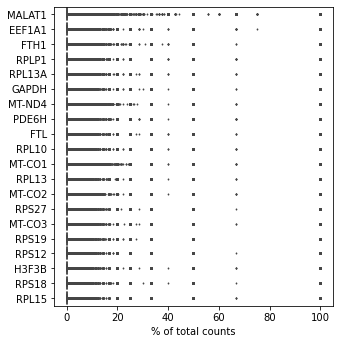

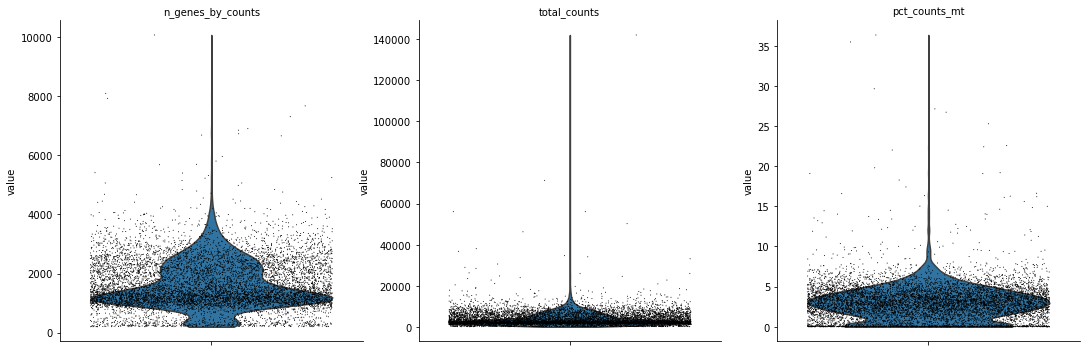

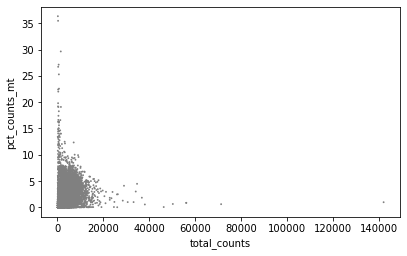

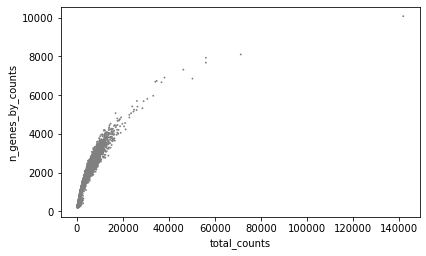

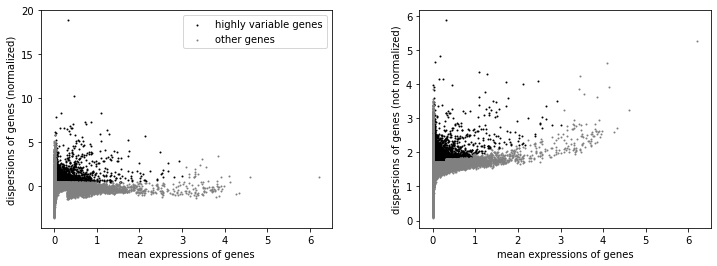

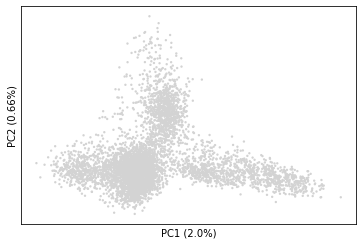

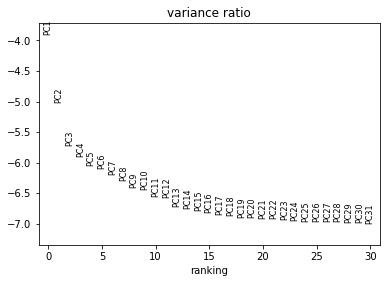

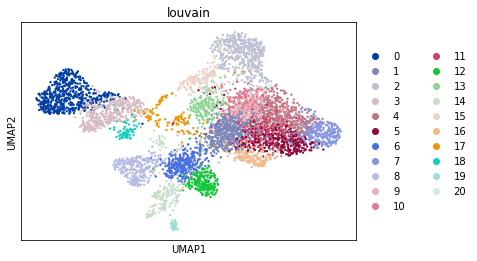

In [73]:
PreprocessSC(data_path = '/data/bioinf/projects/data/2018_scanpyTutorial/input/sc_hROHT/S3_CTRL_HRO2/raw_gene_bc_matrices/hg38.e87/',
             data_type = 'CTRL_3')
ClusterCells(adata_input = adata, 
               cutoff_mito = 4, 
               cutoff_ngenes = 2500, 
               resolution_lv = 2, 
               data_type = 'CTRL_3_higherResolution')

Prepare the dotplots showing the expression of marker genes across the louvain clusters

According to the result of the Master GOI analysis the Louvain clusters are annotated

... storing 'CaSTLe' as categorical


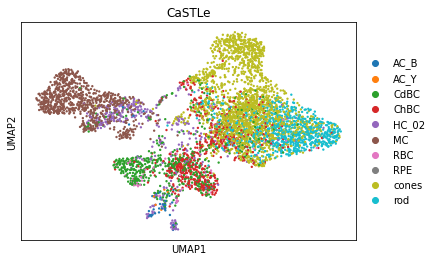

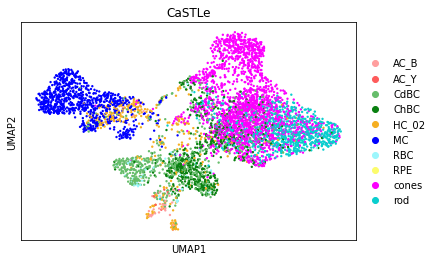

In [74]:
CaSTLE = pd.read_csv("/data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/csvs/CaSTLe_Annot_output_Control_3_Organoid_cellnames.csv")
CaSTLE
adata.obs["CaSTLe"] = CaSTLE.iloc[:, 1].values
sc.pl.umap(adata, color=['CaSTLe'])
adata.uns['CaSTLe_colors'] = ['#FF9E9E',  '#FE5B5B',  
                              '#66BD6B', '#098010', '#F5AF22',  '#0000FF', 
                              '#9CF6FC', '#FCFC6C', '#FC00FF', '#09CECE']
sc.pl.umap(adata, color=['CaSTLe'])
control_3 = adata

Correctly assign the colors.

Prepare the pie charts

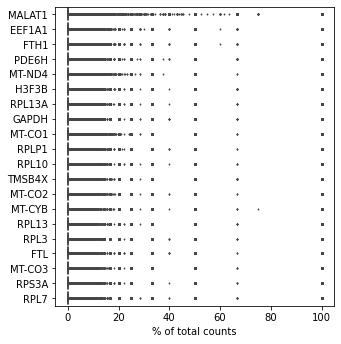

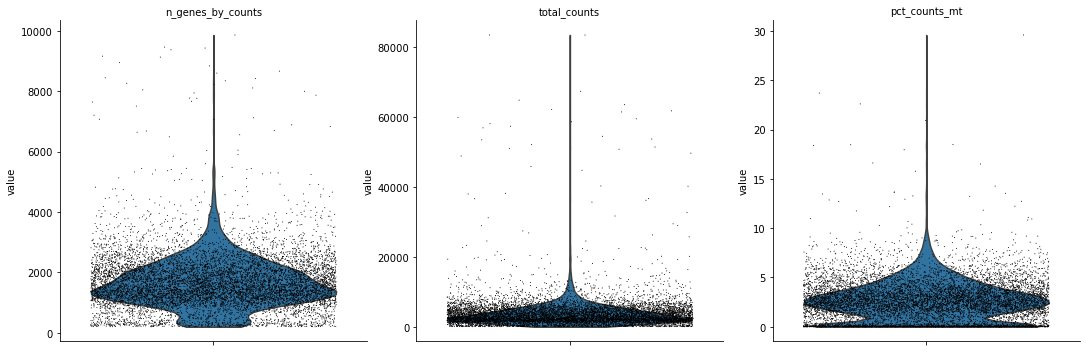

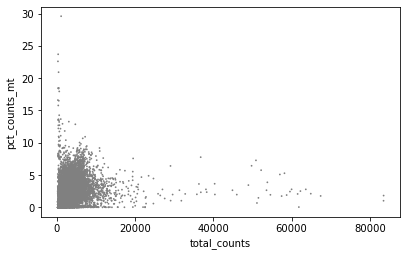

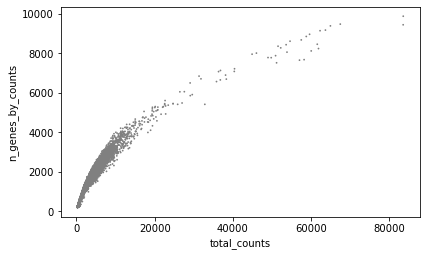

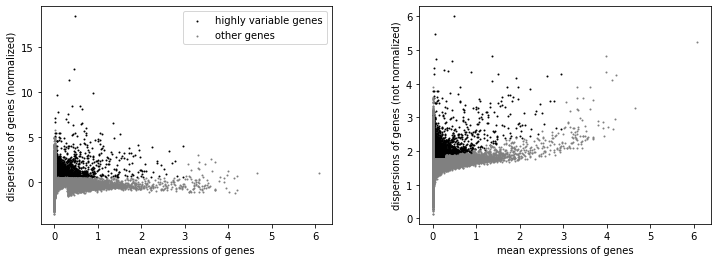

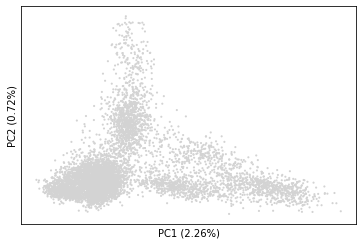

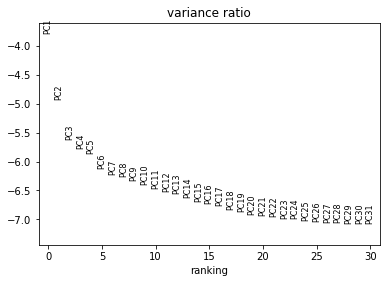

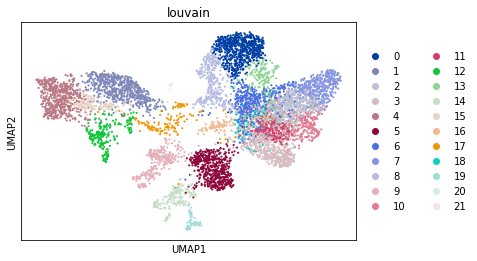

In [75]:
PreprocessSC(data_path = '/data/bioinf/projects/data/2018_scanpyTutorial/input/sc_hROHT/S2_CTRL_HRO1/outs/raw_gene_bc_matrices/hg38.e87/',
             data_type = 'CTRL_2')
ClusterCells(adata_input = adata, 
               cutoff_mito = 4, 
               cutoff_ngenes = 2500, 
               resolution_lv = 2, 
               data_type = 'CTRL_2_higherResolution')


... storing 'CaSTLe' as categorical


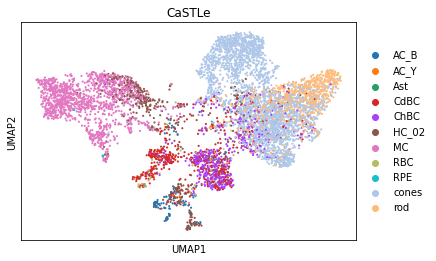

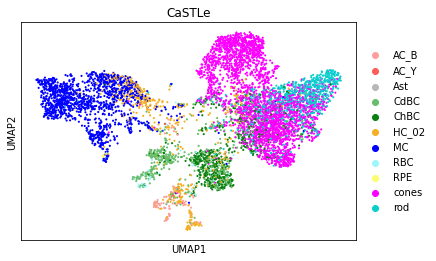

In [76]:
CaSTLE = pd.read_csv("/data/bioinf/projects/data/2019_schROHT/2021_CaSTLeAnnot/csvs/CaSTLe_Annot_output_Control_2_Organoid_cellnames.csv")
CaSTLE
adata.obs["CaSTLe"] = CaSTLE.iloc[:, 1].values
sc.pl.umap(adata, color=['CaSTLe'])
adata.uns['CaSTLe_colors'] = ['#FF9E9E',  '#FE5B5B',  '#B9B8B8',
                              '#66BD6B', '#098010', '#F5AF22',  '#0000FF', 
                              '#9CF6FC', '#FCFC6C', '#FC00FF', '#09CECE']
sc.pl.umap(adata, color=['CaSTLe'])
control_2 = adata

In [ ]:
# Merging both datasets

In [77]:
merge = control_2.concatenate(control_3, batch_categories=['HRO_2', 'HRO_3'])

... storing 'louvain' as categorical
... storing 'CaSTLe' as categorical


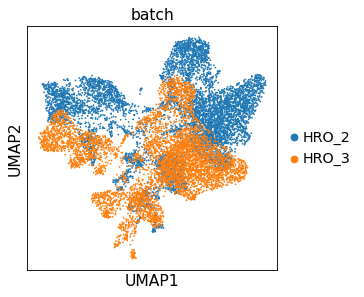

In [10]:
sc.pl.umap(merge, color=['batch'])

In [147]:
# Ingest

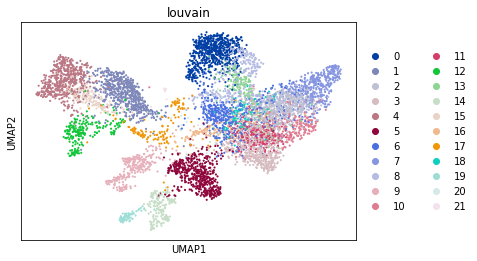

In [78]:
var_names = control_2.var_names.intersection(control_3.var_names)
control_2 = control_2[:, var_names]
control_3 = control_3[:, var_names]
sc.pp.pca(control_2)
sc.pp.neighbors(control_2)
sc.tl.umap(control_2)
sc.pl.umap(control_2, color='louvain')


In [79]:
sc.tl.ingest(control_3, control_2, obs='louvain')

In [80]:
adata_concat = control_2.concatenate(control_3, batch_categories=['HRO-2', 'HRO-3'])


... storing 'CaSTLe' as categorical


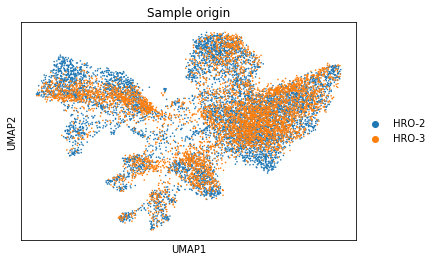

In [81]:
sc.pl.umap(adata_concat,title='Sample origin', color=['batch'])

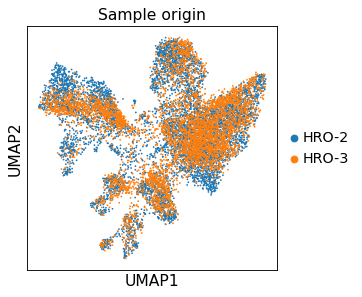

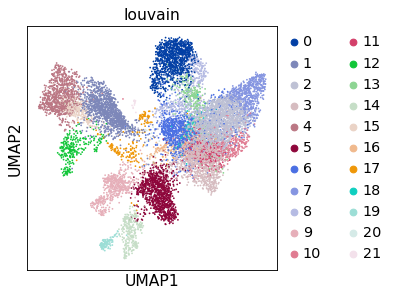

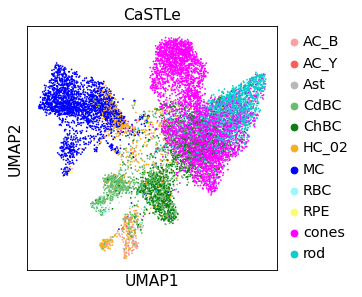

In [88]:
sc.pl.umap(adata_concat, color=['batch'], title="Sample origin", save= "VarAna_UMAP_MergedHROs_batches.svg")
sc.pl.umap(adata_concat, color=['louvain'])
sc.pl.umap(adata_concat, color=['CaSTLe'])

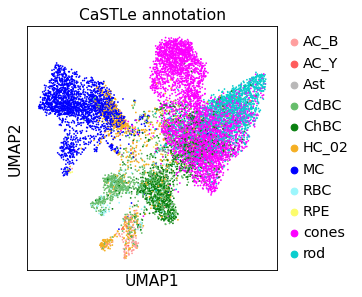

In [93]:
adata_concat.uns['CaSTLe_colors'] = ['#FF9E9E',  '#FE5B5B',  '#B9B8B8',
                              '#66BD6B', '#098010', '#F5AF22',  '#0000FF', 
                              '#9CF6FC', '#FCFC6C', '#FC00FF', '#09CECE']
sc.pl.umap(adata_concat, color=['CaSTLe'], title="CaSTLe annotation", save= "VarAna_UMAP_MergedHROs.svg")

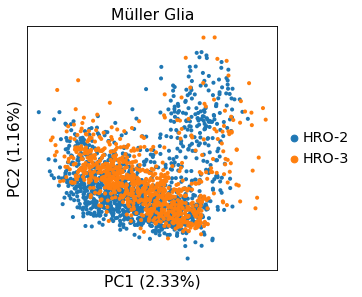

In [94]:
subset_Mg = adata_concat[adata_concat.obs['CaSTLe'] == "MC",]
subset_Mg
sc.tl.pca(subset_Mg, svd_solver='arpack')
#sc.pl.pca(subset_Mg,  annotate_var_explained=True, color=['batch'], title= "MC_01")
sc.pl.pca(subset_Mg, annotate_var_explained=True, color=['batch'], title= "Müller Glia", save="VarAna_MC.svg")

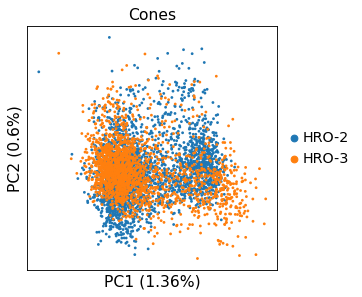

In [95]:
subset_cones = adata_concat[adata_concat.obs['CaSTLe'] == "cones",]
subset_cones
sc.tl.pca(subset_cones, svd_solver='arpack')
sc.pl.pca(subset_cones, annotate_var_explained=True, color=['batch'], title= "Cones", save="VarAna_cones.svg")

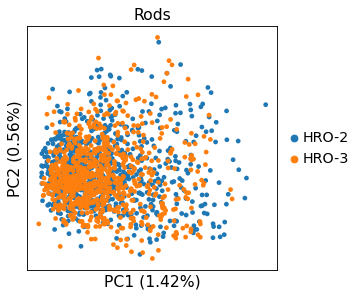

In [96]:
subset_rod = adata_concat[adata_concat.obs['CaSTLe'] == "rod",]
subset_rod
sc.tl.pca(subset_rod, svd_solver='arpack')
sc.pl.pca(subset_rod, annotate_var_explained=True, color=['batch'], title= "Rods", save="VarAna_rod.svg")